# Clustering Report for Sporting Cristal

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Functions

In [76]:
#############################################################################################
''' DEFINING NUMBER OF CLUSTERS + GENERATION '''
#############################################################################################

def clusters(num_clusters):
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_scaled)
    labels = kmeans_model.labels_

    print(f'\n Inertia Score: {kmeans_model.inertia_} \n')

    plt.scatter(df_first['Talla'], df_first['Edad'], c=labels, cmap='viridis')
    plt.xlabel('Talla')
    plt.ylabel('Edad')
    plt.title('Clustering Results')
    plt.show()
    
    df_first['Cluster'] = kmeans_model.fit_predict(df_scaled)
    
    return df_first

#############################################################################################
''' DEFINING NUMBER OF CLUSTERS + GENERATION (Without Standardization) '''
#############################################################################################


def clusters_(num_clusters):
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_first_X)
    labels = kmeans_model.labels_

    print(f'\n Inertia Score: {kmeans_model.inertia_} \n')

    plt.scatter(df_first['Talla'], df_first['Edad'], c=labels, cmap='viridis')
    plt.xlabel('Talla')
    plt.ylabel('Edad')
    plt.title('Clustering Results')
    plt.show()
    
    df_first['Cluster'] = kmeans_model.fit_predict(df_first_X)
    
    return df_first

#############################################################################################
''' CLUSTERING BASED ON AGE '''
#############################################################################################

def clusters_age(num_clusters):
    # selecting only the 'Edad' column
    df_age = df_first[['Edad']]

    # applying k-means clustering
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_age)
    labels = kmeans_model.labels_

    print(f'\n Inertia Score: {kmeans_model.inertia_} \n')

    plt.scatter(df_age['Edad'], np.zeros_like(df_age['Edad']), c=labels, cmap='viridis')
    plt.xlabel('Edad')
    plt.title('Clustering Results based on Age')
    plt.show()

    df_first['Cluster'] = kmeans_model.fit_predict(df_age)
    
    return df_first

#############################################################################################
''' CLUSTERING BASED ON AGE WITH MANIPULATION OF HEIGHT MAGNITUDES (For improved Explainability) '''
#############################################################################################

def clusters_age_h(num_clusters):
    
    df_copy = df_first.copy()
    
    # Converting height from centimeters to meters
    df_copy['Talla_metros'] = df_copy['Talla'] / 100

    # Selecting only the 'Height_meters' and 'Edad' columns
    df_height = df_copy[['Talla_metros', 'Edad']]

    # Applying k-means clustering
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_height)
    labels = kmeans_model.labels_

    print(f'\n Inertia Score: {kmeans_model.inertia_} \n')

    plt.scatter(df_height['Talla_metros'], df_height['Edad'], c=labels, cmap='viridis')
    plt.xlabel('Height (meters)')
    plt.ylabel('Edad')
    plt.title('Clustering Results based on Adjusted Height')
    plt.show()

    df_copy['Cluster'] = kmeans_model.fit_predict(df_height)
    
    return df_copy




#############################################################################################
''' GENERATING STAT RANGES/INTERVALS FUNCTION '''
#############################################################################################
'''
def cluster_stats(df):
    # calculate descriptive statistics for each cluster
    cluster_stats = df.groupby('Cluster')[['Edad', 'Talla']].describe()
    return cluster_stats[[('Edad', 'min'), ('Edad', 'max'),
                      ('Talla', 'min'), ('Talla', 'max')]]
'''
def cluster_stats(df):
    # calculate descriptive statistics for each cluster
    cluster_stats = df.groupby('Cluster')[['Edad', 'Talla']].describe()
    cluster_stats_means = df.groupby('Cluster')[['Edad', 'Talla']].mean()
    cluster_stats = pd.concat([cluster_stats, cluster_stats_means], axis=1)
    return cluster_stats[[('Edad', 'min'), ('Edad', 'max'), ('Edad', 'mean'),
                          ('Talla', 'min'), ('Talla', 'max'), ('Talla', 'mean')]]



#############################################################################################
''' Function generating final list by only target variables - REVISED VERSION WORKS BETTER'''
#############################################################################################


def new_reference_values_list(df):
    
    # variables of interest
    variables = ['ID', 'MA_Kg','MM_Kg', 'Sum6Pliegues', 'Cluster']
    df = df[variables]
    interest_variables = ['MA_Kg','MM_Kg', 'Sum6Pliegues']
    
    # separate values into clusters
    # convert it into a dictionary
    cluster_datasets = {cluster: group for cluster, group in df.groupby('Cluster')}
    
    
    def reference_values(df, variable):

        # using interquartile ranges as reference values
        quartiles = df[variable].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

        # defining the ranges basde on quartiles
        range_0_20 = (quartiles.iloc[0], quartiles.iloc[1])
        range_20_40 = (quartiles.iloc[1], quartiles.iloc[2])
        range_40_60 = (quartiles.iloc[2], quartiles.iloc[3])
        range_60_80 = (quartiles.iloc[3], quartiles.iloc[4])
        range_80_100 = (quartiles.iloc[4], quartiles.iloc[5])

        # function creation for string creation
        def classify_group(value):
            if value <= range_0_20[1]: # we use 1 as index to get the highest of the range
                return '0-20'
            elif value <= range_20_40[1]:
                return '20-40'
            elif value <= range_40_60[1]:
                return '40-60'
            elif value <= range_60_80[1]:
                return '60-80'
            else: 
                return '80-100'

        # applying the function to create new column with the group classification
        if variable == 'MM_Kg':
            df['MM_Kg - Grouping'] = df['MM_Kg'].apply(classify_group)
        elif variable == 'MA_Kg':
            df['MA_Kg - Grouping'] = df['MA_Kg'].apply(classify_group)
        elif variable == 'Sum6Pliegues':
            df['SumPliegues - Grouping'] = df['Sum6Pliegues'].apply(classify_group)

        return df
    
    final_list = []        
    
    for key in cluster_datasets:
        for var in interest_variables:
            a = reference_values(cluster_datasets[key], var)
            final_list.append(a)
    
    final_df = pd.concat(final_list, ignore_index=True)
    
    return final_df # here it should be a 'final_df'



#############################################################################################
''' REVISED: Function generating final dataframe by only target variables '''
#############################################################################################

def new_reference_values(df):
    
    # variables of interest
    interest_variables = ['MA_Kg','MM_Kg', 'Sum6Pliegues']
    
    # separate values into clusters
    cluster_datasets = {cluster: group for cluster, group in df.groupby('Cluster')}
    
    def classify_group(value, ranges):
        for i, r in enumerate(ranges):
            if value <= r[1]:
                return f'{i * 20}-{(i + 1) * 20}'
        return '80-100'
    
    final_dfs = []  
    
    for key in cluster_datasets:
        cluster_df = cluster_datasets[key].copy()  # creating copy to avoid modifying the original DataFrame
        for var in interest_variables:
            # calculating reference values
            quartiles = cluster_df[var].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
            ranges = [(quartiles.iloc[i], quartiles.iloc[i+1]) for i in range(5)]
            
            # apply classification function
            cluster_df[f'{var} - Grouping'] = cluster_df[var].apply(lambda x: classify_group(x, ranges))
        
        final_dfs.append(cluster_df)
    
    final_df = pd.concat(final_dfs)  # Concatenate all DataFrames into a single DataFrame
    
    return final_df

#############################################################################################
''' Visualizing Final DataFrame BoxPlot Distribution'''
#############################################################################################

def visualize_clusters(df, cluster_variable):
    # Set variables for box plots
    boxplot_variables = ['MA_Kg', 'MM_Kg', 'Sum6Pliegues']
    
    # Set style
    sns.set(style="whitegrid")
    
    # Create a figure and axes
    fig, axes = plt.subplots(1, len(boxplot_variables), figsize=(18, 6))
    
    # Loop through each box plot variable
    for i, var in enumerate(boxplot_variables):
        # Create a box plot for each variable
        sns.boxplot(data=df, x=cluster_variable, y=var, ax=axes[i])
        axes[i].set_title(f'{var} by {cluster_variable}')
        axes[i].set_xlabel(cluster_variable)
        axes[i].set_ylabel(var)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()


## Data Exploration & Cleaning 
### Selecting first records for each player

In [34]:
df = pd.read_csv('dataset_antropometria.csv')
df.head(3)

# sort records by ID and date
df.sort_values(by=['ID', 'Fecha'], inplace=True)
df.reset_index()

# keep first observation for each player
df_first = df.groupby('ID').first().reset_index()
df_first.head(3)

df_first.describe()

#investigate the 90 cm tall player
df_first[df_first['Talla'] ==90.8]

df_first.drop([158], inplace = True)

# delete the players under 'Prueba'
df_first = df_first[df_first['Categoría'] != 'Prueba']

df_first.describe()

# we'll delete this record as it is an outlier and the k-means clustering is sensitive to them
# additionally, having a 18 year old player with an Height of 90.8 doesn't make sense.

,ID,Correlativo,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,MO_kg,MM_Per,...,MusloMedio,Pierna,Triceps,Subescapular,Supraespinal,Abdominal,Muslo,Pantorrilla,Nro_Evaluacion,MG_Per
count,2.220000e+02,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,...,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,157.000000
mean,1.000014e+07,309.351351,15.078829,169.721622,16.448918,61.260811,24.120833,14.674383,7.937325,45.525511,...,50.156757,34.710360,7.833333,8.159009,8.212162,10.458108,8.402703,6.284234,1.229730,14.280828
std,8.663558e+01,351.301888,1.906681,9.788361,8.334302,10.492348,3.089392,2.670220,1.378943,3.755017,...,4.581689,2.645876,1.924518,2.585862,1.922523,3.821907,2.474758,2.240510,1.120124,3.106207
min,1.000000e+07,1.000000,11.600000,139.400000,1.957200,31.300000,18.190000,8.482000,4.879000,34.230877,...,26.800000,25.700000,4.000000,4.200000,4.000000,2.500000,2.000000,2.000000,1.000000,9.810000
25%,1.000006e+07,56.250000,13.425000,165.000000,3.381400,54.700000,21.920129,13.056082,7.242730,43.114677,...,47.500000,33.100000,6.600000,7.000000,7.050000,7.800000,6.900000,4.600000,1.000000,12.250000
50%,1.000013e+07,111.500000,14.900000,170.250000,20.473385,62.500000,23.630000,14.575332,8.056931,45.495106,...,50.500000,34.850000,7.500000,7.900000,8.400000,9.600000,8.200000,5.600000,1.000000,13.630000
75%,1.000019e+07,649.500000,16.500000,175.500000,22.082191,68.350000,25.939261,16.266663,8.703870,47.704578,...,53.000000,36.500000,8.800000,9.000000,9.375000,12.750000,9.900000,7.700000,1.000000,15.750000
max,1.000030e+07,1013.000000,20.700000,192.800000,26.661794,88.900000,39.210287,22.605370,17.386720,55.320000,...,62.200000,42.000000,15.800000,38.100000,13.700000,27.400000,19.500000,15.100000,9.000000,30.100000


In [35]:
df_first.head()

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Pierna,Triceps,Subescapular,Supraespinal,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per
0,10000000,256,2023-03-09,Sub-15,15.1,178.0,20.767580,65.8,29.922027,19.688694,...,34.7,9.4,11.1,10.4,20.2,10.2,8.8,2023-10-19 19:58:19.247,1,NaN
1,10000001,109,2023-01-09,Sub-18,17.7,174.5,22.265827,67.8,21.243198,14.402888,...,37.5,5.7,7.5,8.4,6.8,6.9,5.6,2023-10-19 19:58:19.247,1,NaN
2,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,31.4,4.4,5.1,7.2,2.5,5.4,3.5,2023-10-19 19:58:19.247,1,NaN
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,34.1,7.6,7.8,7.4,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,33.4,6.6,7.1,8.7,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79


## Clusters 4,5,6 - (0.5) Weighted K-means Clusters

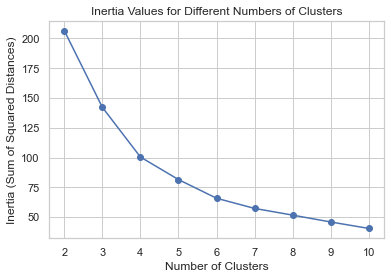

In [36]:
# keeping a dataframe only with the interested features
df_first_X = df_first[['Edad', 'Talla']]
df_first_X.head()

### Visualizing Inertia Scores ####

# Standardize the features. Featuring Scaling method where values are centered around the mean with a unit standard deviation

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_first_X)

# setting a range of cluster values to iterate over and see inertia scores for each
cluster_range = range(2,11) 

inertia_values = []

for num_clusters in cluster_range:
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_model.fit(df_scaled)
    inertia_values.append(kmeans_model.inertia_)
    
# visualizing inertia graph
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Inertia Values for Different Numbers of Clusters')
plt.show()

### 4 Clusters


 Inertia Score: 100.4175380908589 



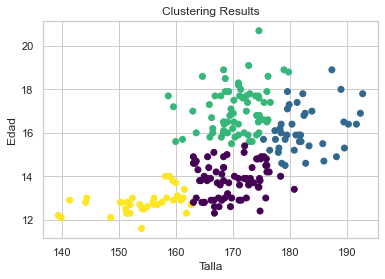

,"(Edad, min)","(Edad, max)","(Edad, mean)","(Talla, min)","(Talla, max)","(Talla, mean)"
Cluster,,,,,,
0,12.3,15.4,13.829730,163.1,180.8,169.908108
1,14.5,18.9,16.156098,175.4,192.8,182.558537
2,15.5,20.7,17.042029,158.7,179.8,170.549275
3,11.6,14.0,12.784211,139.4,162.7,154.005263


In [37]:
four_clusters = clusters(4)
cluster_stats(four_clusters)

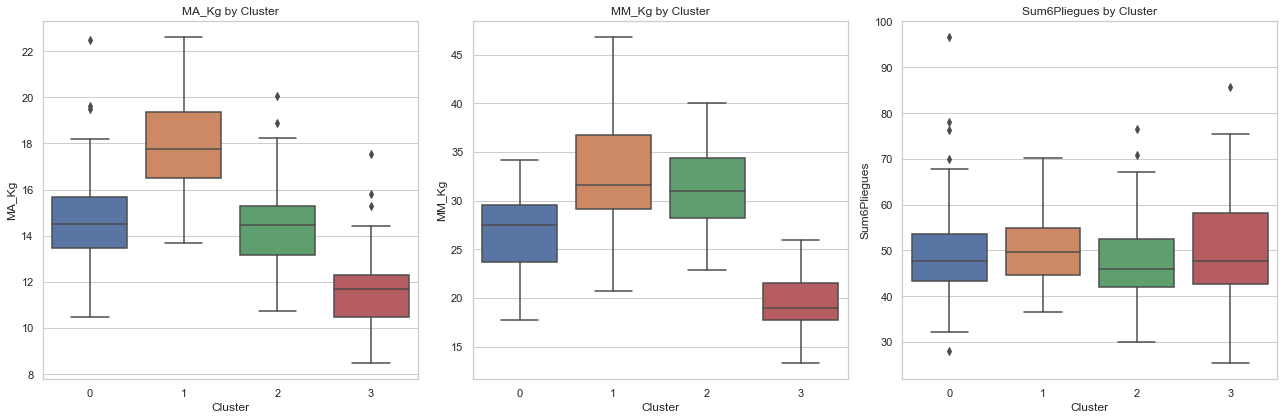

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
2,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,2.5,5.4,3.5,2023-10-19 19:58:19.247,1,NaN,0,0-20,0-20,0-20
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,20-40,40-60,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,0-20,40-60
7,10000009,61,2023-01-13,Sub-14,13.9,174.7,20.609376,62.9,24.205718,15.225397,...,7.3,8.4,7.7,2023-10-19 19:58:19.247,1,13.23,0,60-80,40-60,40-60
9,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,8.6,9.2,6.9,2023-10-19 19:58:19.247,1,30.10,0,20-40,20-40,20-40


In [38]:
new_df_four_clusters = new_reference_values(four_clusters)
visualize_clusters(new_df_four_clusters, 'Cluster')
new_df_four_clusters.head()

### 5 Clusters


 Inertia Score: 81.49371231476876 



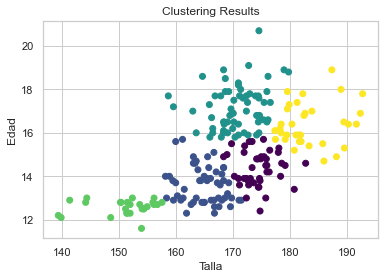

,"(Edad, min)","(Edad, max)","(Edad, mean)","(Talla, min)","(Talla, max)","(Talla, mean)"
Cluster,,,,,,
0,12.4,15.7,14.352273,168.4,182.8,174.465909
1,12.3,15.7,13.587037,158.2,171.5,164.922222
2,15.8,20.7,17.154688,158.7,179.8,170.790625
3,11.6,13.0,12.576923,139.4,157.6,151.115385
4,14.7,18.9,16.394118,177.4,192.8,183.420588


In [39]:
five_clusters = clusters(5)
cluster_stats(five_clusters)

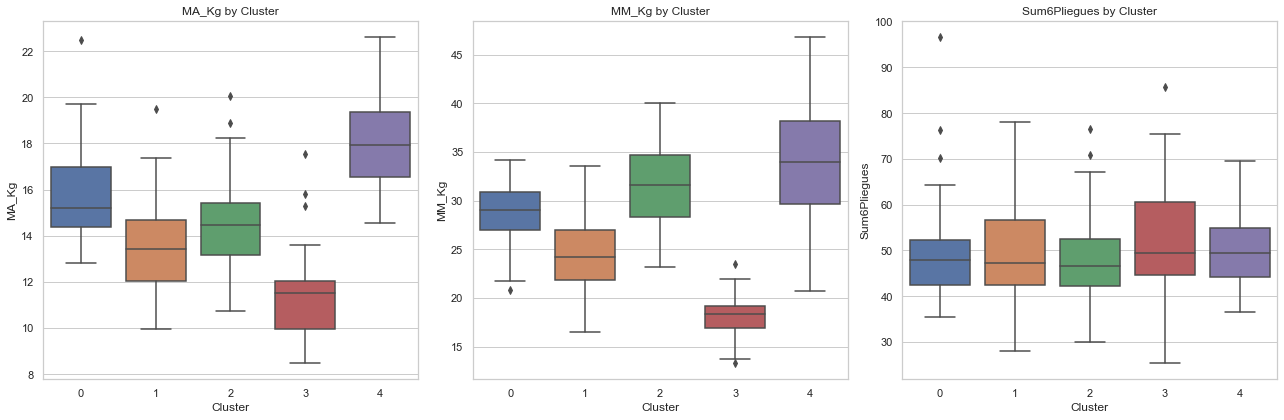

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
0,10000000,256,2023-03-09,Sub-15,15.1,178.0,20.767580,65.8,29.922027,19.688694,...,20.2,10.2,8.8,2023-10-19 19:58:19.247,1,NaN,0,80-100,20-40,80-100
7,10000009,61,2023-01-13,Sub-14,13.9,174.7,20.609376,62.9,24.205718,15.225397,...,7.3,8.4,7.7,2023-10-19 19:58:19.247,1,13.23,0,40-60,20-40,40-60
18,10000022,67,2023-01-13,Sub-14,13.5,174.6,21.223441,64.7,26.230205,16.970942,...,10.0,6.9,10.9,2023-10-19 19:58:19.247,1,13.28,0,60-80,20-40,80-100
21,10000025,65,2023-01-13,Sub-14,13.6,172.8,23.643797,70.6,27.805317,19.630554,...,20.6,12.3,10.9,2023-10-19 19:58:19.247,1,14.09,0,80-100,40-60,80-100
24,10000028,90,2023-01-12,Sub-15,14.8,175.9,23.076319,71.4,21.685391,15.483369,...,8.9,8.9,5.6,2023-10-19 19:58:19.247,1,12.65,0,40-60,80-100,40-60


In [40]:
new_df_five_clusters = new_reference_values(five_clusters)
visualize_clusters(new_df_five_clusters, 'Cluster')
new_df_five_clusters.head()

### 6 Clusters


 Inertia Score: 65.81793233598881 



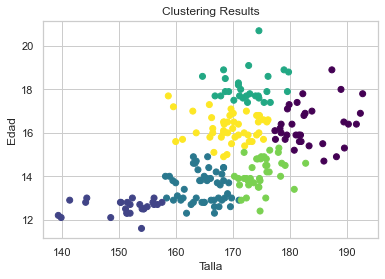

,"(Edad, min)","(Edad, max)","(Edad, mean)","(Talla, min)","(Talla, max)","(Talla, mean)"
Cluster,,,,,,
0,14.7,18.9,16.348485,177.4,192.8,183.536364
1,11.6,13.0,12.576923,139.4,157.6,151.115385
2,12.3,14.9,13.488000,158.2,171.1,164.928000
3,17.4,20.7,18.110714,164.7,179.8,172.585714
4,12.4,15.3,14.123684,170.3,182.8,174.921053
5,14.9,17.7,16.229787,158.7,176.2,169.504255


In [41]:
six_clusters = clusters(6)
cluster_stats(six_clusters)

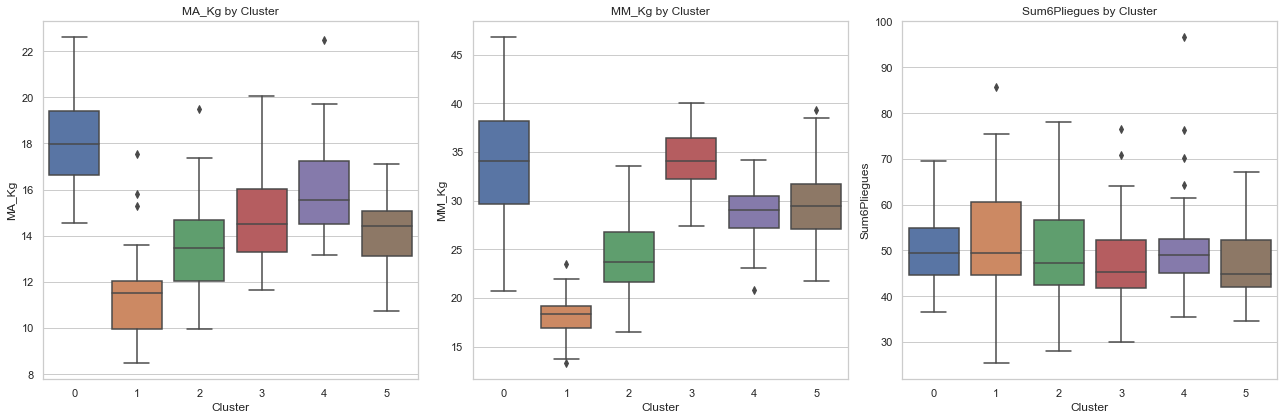

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
10,10000014,840,2023-01-07,Reserva,17.3,179.9,3.236400,75.0,20.780000,15.583000,...,8.0,7.5,3.0,2024-01-27 20:03:20.700,6,12.15,0,0-20,80-100,0-20
12,10000016,89,2023-01-12,Sub-15,14.7,186.0,19.482021,67.4,25.628816,17.273822,...,9.4,9.9,7.7,2023-10-19 19:58:19.247,1,17.77,0,40-60,0-20,60-80
32,10000037,3,2023-01-11,Sub-16,15.9,181.6,19.406548,64.0,23.176471,14.832942,...,5.7,5.9,4.6,2023-10-19 19:58:19.247,1,NaN,0,0-20,0-20,0-20
38,10000043,116,2023-01-09,Sub-17,17.0,183.9,22.413297,75.8,25.575727,19.386401,...,9.4,9.9,9.3,2023-10-19 19:58:19.247,1,NaN,0,60-80,40-60,60-80
51,10000057,239,2023-03-04,Sub-17,17.1,179.6,21.329259,68.8,29.378354,20.212307,...,17.0,11.2,9.8,2023-10-19 19:58:19.247,1,NaN,0,80-100,20-40,80-100


In [42]:
new_df_six_clusters = new_reference_values(six_clusters)
visualize_clusters(new_df_six_clusters, 'Cluster')
new_df_six_clusters.head()

## Clusters 4,5,6 - Height Based - No Standardization

### 4 Clusters


 Inertia Score: 3117.1976092759123 



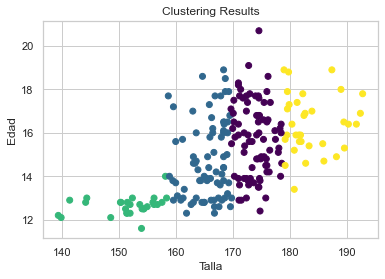

,"(Edad, min)","(Edad, max)","(Edad, mean)","(Talla, min)","(Talla, max)","(Talla, mean)"
Cluster,,,,,,
0,12.4,20.7,15.684337,169.7,178.6,173.883133
1,12.3,18.9,14.733766,158.7,169.8,165.618182
2,11.6,14.0,12.642857,139.4,158.4,151.628571
3,13.4,18.9,16.388235,179.0,192.8,183.755882


In [43]:
four_clusters_ = clusters_(4)
cluster_stats(four_clusters_)

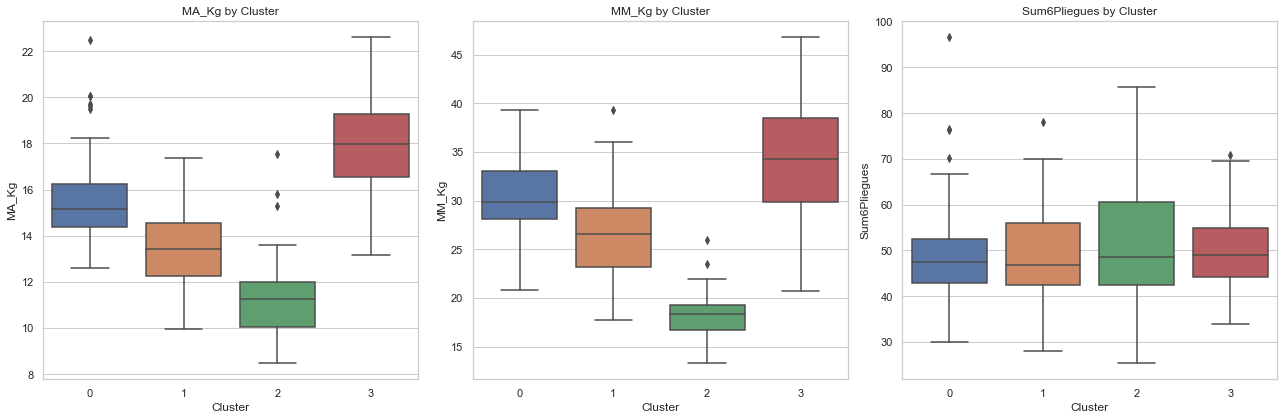

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
0,10000000,256,2023-03-09,Sub-15,15.1,178.0,20.767580,65.8,29.922027,19.688694,...,20.2,10.2,8.8,2023-10-19 19:58:19.247,1,NaN,0,80-100,0-20,80-100
1,10000001,109,2023-01-09,Sub-18,17.7,174.5,22.265827,67.8,21.243198,14.402888,...,6.8,6.9,5.6,2023-10-19 19:58:19.247,1,NaN,0,20-40,60-80,0-20
7,10000009,61,2023-01-13,Sub-14,13.9,174.7,20.609376,62.9,24.205718,15.225397,...,7.3,8.4,7.7,2023-10-19 19:58:19.247,1,13.23,0,40-60,0-20,40-60
11,10000015,23,2023-01-10,Sub-17,15.9,174.2,18.882449,57.3,28.536402,16.351359,...,11.0,7.9,6.7,2023-10-19 19:58:19.247,1,17.37,0,60-80,0-20,40-60
18,10000022,67,2023-01-13,Sub-14,13.5,174.6,21.223441,64.7,26.230205,16.970942,...,10.0,6.9,10.9,2023-10-19 19:58:19.247,1,13.28,0,80-100,0-20,60-80


In [44]:
new_df_four_clusters_ = new_reference_values(four_clusters_)
visualize_clusters(new_df_four_clusters_, 'Cluster')
new_df_four_clusters_.head()

### 5 Clusters


 Inertia Score: 2329.962672188921 



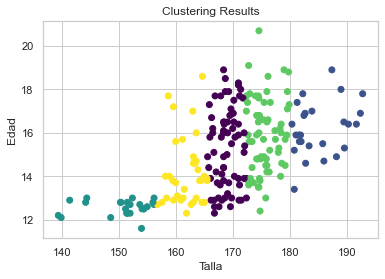

,"(Edad, min)","(Edad, max)","(Edad, mean)","(Talla, min)","(Talla, max)","(Talla, mean)"
Cluster,,,,,,
0,12.3,18.9,15.292857,165.6,172.4,168.985714
1,13.4,18.9,16.196154,180.4,192.8,185.073077
2,11.6,13.0,12.562500,139.4,156.2,150.608333
3,12.4,20.7,15.843939,172.4,179.9,175.625758
4,12.3,18.6,14.130556,156.8,165.5,161.983333


In [45]:
five_clusters_ = clusters_(5)
cluster_stats(five_clusters_)

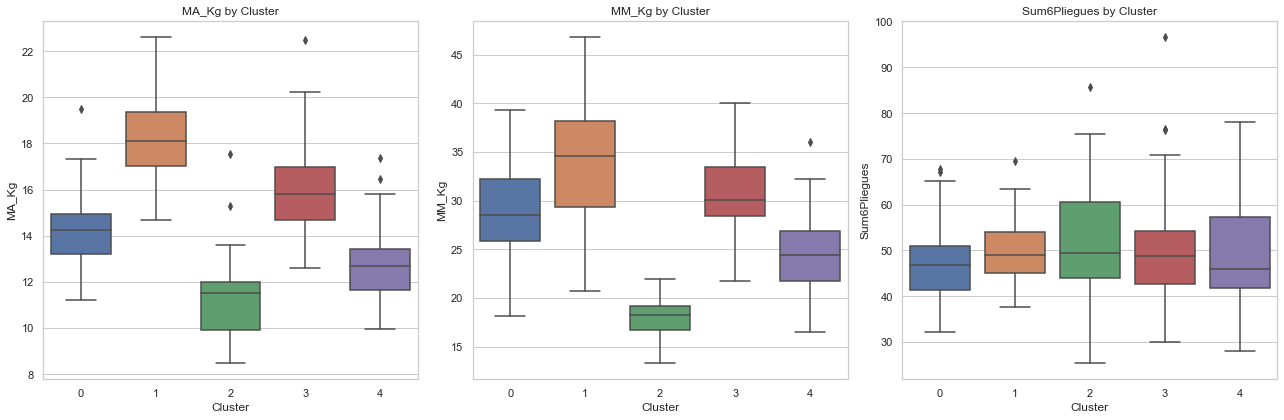

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,20-40,20-40,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,0-20,60-80
9,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,8.6,9.2,6.9,2023-10-19 19:58:19.247,1,30.10,0,40-60,20-40,40-60
16,10000020,1008,2023-03-04,Sub-16,14.4,165.8,2.749000,54.1,20.690000,11.191000,...,9.0,7.0,4.0,2024-01-27 20:03:20.700,1,12.07,0,0-20,0-20,0-20
20,10000024,64,2023-01-13,Sub-14,13.9,166.1,18.847948,52.0,28.072208,14.597548,...,5.7,10.8,9.3,2023-10-19 19:58:19.247,1,16.54,0,60-80,0-20,40-60


In [46]:
new_df_five_clusters_ = new_reference_values(five_clusters_)
visualize_clusters(new_df_five_clusters_, 'Cluster')
new_df_five_clusters_.head()

### 6 Clusters


 Inertia Score: 1758.3127246500853 



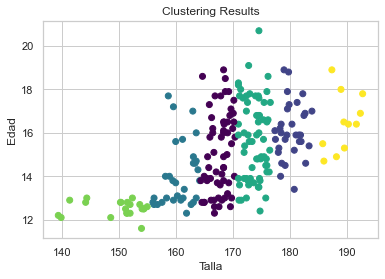

,"(Edad, min)","(Edad, max)","(Edad, mean)","(Talla, min)","(Talla, max)","(Talla, mean)"
Cluster,,,,,,
0,12.3,18.9,15.086885,164.4,170.4,167.747541
1,13.4,18.9,16.103125,177.4,183.9,180.259375
2,12.3,17.7,14.022581,156.0,164.2,160.648387
3,12.4,20.7,15.650000,171.0,176.6,173.762121
4,11.6,13.0,12.523810,139.4,155.0,149.819048
5,14.7,18.9,16.481818,185.8,192.8,189.336364


In [47]:
six_clusters_ = clusters_(6)
cluster_stats(six_clusters_)

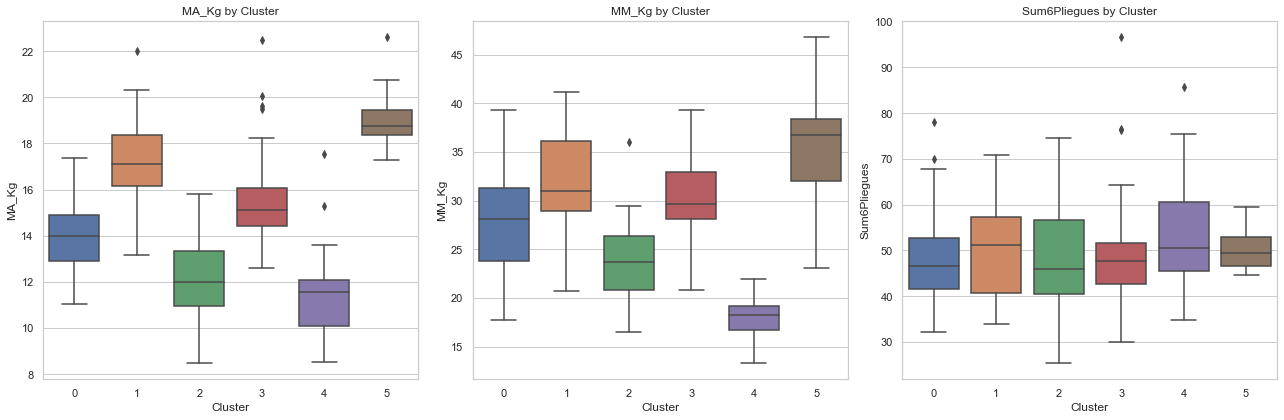

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,MA_Kg - Grouping,MM_Kg - Grouping,Sum6Pliegues - Grouping
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,0,20-40,20-40,40-60
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,0,60-80,0-20,60-80
9,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,8.6,9.2,6.9,2023-10-19 19:58:19.247,1,30.10,0,40-60,20-40,40-60
14,10000018,782,2023-01-06,Reserva,18.6,164.7,2.712600,58.2,19.970000,11.626000,...,9.0,9.0,3.5,2024-01-27 20:03:20.700,9,11.48,0,0-20,60-80,0-20
16,10000020,1008,2023-03-04,Sub-16,14.4,165.8,2.749000,54.1,20.690000,11.191000,...,9.0,7.0,4.0,2024-01-27 20:03:20.700,1,12.07,0,0-20,20-40,0-20


In [48]:
new_df_six_clusters_ = new_reference_values(six_clusters_)
visualize_clusters(new_df_six_clusters_, 'Cluster')
new_df_six_clusters_.head()

## Clusters 4,5,6 - Age Based - No Standardization


 Inertia Score: 56.31908515292665 



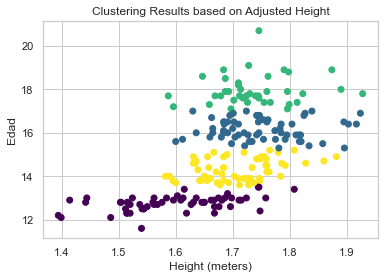


 Inertia Score: 40.50298735768874 



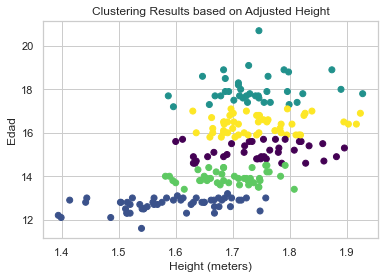


 Inertia Score: 27.34362759259654 



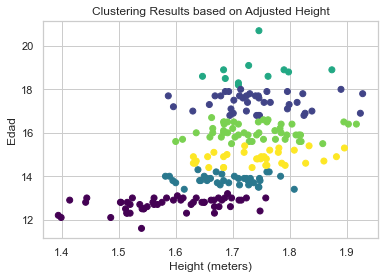

In [82]:
four_clusters_age = clusters_age_h(4)
five_clusters_age = clusters_age_h(5)
six_clusters_age = clusters_age_h(6)

In [83]:
four_clusters_age

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,Subescapular,Supraespinal,Abdominal,Muslo,Pantorrilla,Fecha_registro,Nro_Evaluacion,MG_Per,Cluster,Talla_metros
0,10000000,256,2023-03-09,Sub-15,15.1,178.0,20.767580,65.8,29.922027,19.688694,...,11.1,10.4,20.2,10.2,8.8,2023-10-19 19:58:19.247,1,NaN,3,1.780
1,10000001,109,2023-01-09,Sub-18,17.7,174.5,22.265827,67.8,21.243198,14.402888,...,7.5,8.4,6.8,6.9,5.6,2023-10-19 19:58:19.247,1,NaN,2,1.745
2,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,5.1,7.2,2.5,5.4,3.5,2023-10-19 19:58:19.247,1,NaN,3,1.634
3,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,7.8,7.4,9.6,9.2,5.9,2023-10-19 19:58:19.247,1,NaN,3,1.684
4,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,7.1,8.7,11.0,8.4,7.7,2023-10-19 19:58:19.247,1,12.79,3,1.681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,10000298,926,2024-01-22,Sub-13,12.7,156.8,2.458600,44.7,24.820000,11.094000,...,6.4,6.0,10.0,9.8,6.2,2024-01-27 20:03:20.700,1,15.75,0,1.568
237,10000299,927,2024-01-22,Sub-13,13.0,144.4,2.085100,39.0,21.870000,8.530000,...,4.6,6.2,5.6,11.2,4.0,2024-01-27 20:03:20.700,1,13.08,0,1.444
238,10000300,928,2024-01-22,Sub-13,12.9,141.4,1.999400,36.3,29.630000,10.755000,...,9.0,6.8,13.0,16.0,8.8,2024-01-27 20:03:20.700,1,20.58,0,1.414
239,10000301,883,2023-01-06,Reserva,19.1,172.8,2.986000,73.7,19.050000,14.042000,...,8.0,7.0,8.0,5.0,7.0,2024-01-27 20:03:20.700,1,10.73,2,1.728


# Consolidating Datasets into one for Visualization Purposes

In [84]:
# we will use new_df_four_clusters as based, that's why we dot'include it in the 'frames' variable
consolidated_df = new_df_four_clusters.copy()

#frames = [new_df_five_clusters, new_df_six_clusters, new_df_four_clusters_, new_df_five_clusters_, new_df_six_clusters_]
consolidated_df.rename(columns={'Cluster':'Std - 4 Clusters'}, inplace=True)

# creating function for only keeping the 'Cluster' variable
def keeping_needed_variables(df, clustering):
    df = df.copy()
    df = df[['ID', 'Cluster']]
    df.rename(columns={'Cluster':clustering}, inplace=True)
    return df

# applying functions
five_clusters_std = keeping_needed_variables(new_df_five_clusters, 'Std - 5 Clusters')
six_clusters_std = keeping_needed_variables(new_df_six_clusters, 'Std - 6 Clusters')
four_clusters_height = keeping_needed_variables(new_df_four_clusters_, 'Height - 4 Clusters')
five_clusters_height = keeping_needed_variables(new_df_five_clusters_, 'Height - 5 Clusters')
six_clusters_height = keeping_needed_variables(new_df_six_clusters_, 'Height - 6 Clusters')
four_clusters_age = keeping_needed_variables(four_clusters_age, 'Age - 4 Clusters')
five_clusters_age = keeping_needed_variables(five_clusters_age, 'Age - 5 Clusters')
six_clusters_age = keeping_needed_variables(six_clusters_age, 'Age - 6 Clusters')

# merge using left-join (joining based on ID)
merged_df = consolidated_df.merge(five_clusters_std, on='ID', how='left')
merged_df = merged_df.merge(six_clusters_std, on='ID', how='left')
merged_df = merged_df.merge(four_clusters_height, on='ID', how='left')
merged_df = merged_df.merge(five_clusters_height, on='ID', how='left')
merged_df = merged_df.merge(six_clusters_height, on='ID', how='left')
merged_df = merged_df.merge(four_clusters_age, on='ID', how='left')
merged_df = merged_df.merge(five_clusters_age, on='ID', how='left')
merged_df = merged_df.merge(six_clusters_age, on='ID', how='left')

In [85]:
merged_df.to_csv('Consolidated Data.csv', index=False)

In [86]:
merged_df

,ID,Correlativo,Fecha,Categoría,Edad,Talla,IMC,PesoActual_Kg,MA_Per,MA_Kg,...,MM_Kg - Grouping,Sum6Pliegues - Grouping,Std - 5 Clusters,Std - 6 Clusters,Height - 4 Clusters,Height - 5 Clusters,Height - 6 Clusters,Age - 4 Clusters,Age - 5 Clusters,Age - 6 Clusters
0,10000003,87,2023-01-12,Sub-15,14.6,163.4,17.041479,45.5,23.064055,10.494145,...,0-20,0-20,1,2,1,4,2,3,0,5
1,10000004,243,2023-03-09,Sub-15,14.4,168.4,20.417116,57.9,23.057377,13.350222,...,40-60,40-60,1,2,1,0,0,3,3,5
2,10000005,88,2023-01-12,Sub-15,14.1,168.1,20.030003,56.6,26.300509,14.886088,...,0-20,40-60,1,2,1,0,0,3,3,2
3,10000009,61,2023-01-13,Sub-14,13.9,174.7,20.609376,62.9,24.205718,15.225397,...,40-60,40-60,0,4,0,3,3,3,3,2
4,10000013,226,2023-03-08,Sub-14,14.2,167.1,20.736032,57.9,24.603933,14.245677,...,20-40,20-40,1,2,1,0,0,3,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,10000296,924,2024-01-22,Sub-13,12.9,159.6,2.547200,51.3,23.130000,11.868000,...,80-100,40-60,1,2,1,4,2,0,1,0
218,10000298,926,2024-01-22,Sub-13,12.7,156.8,2.458600,44.7,24.820000,11.094000,...,40-60,20-40,3,1,2,4,2,0,1,0
219,10000299,927,2024-01-22,Sub-13,13.0,144.4,2.085100,39.0,21.870000,8.530000,...,20-40,20-40,3,1,2,2,4,0,1,0
220,10000300,928,2024-01-22,Sub-13,12.9,141.4,1.999400,36.3,29.630000,10.755000,...,0-20,80-100,3,1,2,2,4,0,1,0
